In [2]:
%gui wx
%matplotlib inline

In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
import operator
import pickle

/home/raid3/huntenburg/workspace/try_openblas/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
def make_cluster_cmap(c):
    cmap = np.asarray(sns.color_palette('cubehelix', c-1))
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [5]:
def make_cont_cmap(c):
    cmap = np.asarray(sns.cubehelix_palette(c-1, start=.5, rot=-.75, reverse=True))
    #cmap = np.asarray(sns.color_palette('Reds_r', c-1))
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [6]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

### load data

In [7]:
hemi='rh'
embed=10
k=5
smooth='smooth_3'
masktype='02_4'
pal, pal_255 = make_cluster_cmap(k+1)

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/%s_mask.1D.roi'%hemi
#embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s.npy'%(smooth, masktype, hemi, str(embed))
#embed_res_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s_dict.pkl'%(smooth, masktype, hemi, str(embed))
kmeans_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s_kmeans_%s.npy'%(smooth, masktype, hemi, str(embed), str(k))
subclust_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s_kmeans_%s_subclust.npy'%(smooth, masktype, hemi, str(embed), str(k))
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_%s_profiles.npy'%(hemi)

#var_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_var.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#t_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_avg_t.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#p_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_avg_p.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#fig_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_violins.svg'%(str(n_components_kmeans),smooth, sub, hemi)

In [8]:
v,f,d = read_vtk(mesh_file)
x=v[:,0]
y=v[:,1]
z=v[:,2]
triangles=f


mask = np.loadtxt(mask_file)[:,0]
clust=np.load(kmeans_file)
subclust=np.load(subclust_file)
t1=np.load(t1_file)

### plot subcluster on surface

In [112]:
p=6
network = np.zeros_like(clust[:,0])
network[np.where(clust[:,0]==p)]=1

In [113]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=network, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

### Get T1 values in all clusters

In [13]:
# make a list of dictionaries for each cluster k0, k1, ...(0=mask to max kmeans) 
# and subcluster s0_0, s0_1, s0_2, ..(0 to max subcluster)
t1_clust={}
t1_subclust={}
for c in range(int(clust.max()+1)):
    t1_clust['k'+str(c)]=[]
    for s in range(int(subclust[:,c].max()+1)):
        t1_clust['k'+str(c)+'_'+str(s)]=[]

# write all t1 values in one cluster into the list of its dictionary
for i in range(len(t1)):
    kn=int(clust[i])
    sub=int(subclust[:,kn][i])
    t1_clust['k'+str(kn)].append(t1[i])
    t1_subclust['k'+str(kn)+'_'+str(sub)].append(t1[i])

In [53]:
# make other dictionaries with 3 to 7 intracortical profiles and averages, thresholded  1400 to 2500 mean
t1_clust_37={}
t1_clust_37_avg={}
t1_subclust_37={}
t1_subclust_37_avg={}

for c in range(int(clust.max()+1)):
    t1_clust_37['k'+str(c)]=[pro[3:8] for pro in t1_clust['k'+str(c)]
                             if np.mean(pro[3:8]) < 2500
                             and np.mean(pro[3:8]) > 1400]
    t1_clust_37_avg['k'+str(c)]=[np.mean(pro_37) for pro_37 in t1_clust_37['k'+str(c)]]
    
    for s in range(int(subclust[:,c].max()+1)):
        t1_subclust_37['k'+str(c)+'_'+str(s)]=[pro[3:8] for pro in t1_subclust['k'+str(c)+'_'+str(s)]
                                                if np.mean(pro[3:8]) < 2500
                                                and np.mean(pro[3:8]) > 1400]
        t1_subclust_37_avg['k'+str(c)+'_'+str(s)]=[np.mean(pro_37) for pro_37 in t1_subclust_37['k'+str(c)+'_'+str(s)]]

### Plot resorted clusters and T1 distributions

In [127]:
Tclust = t1_clust_37_avg.copy()
Tsubclust = t1_subclust_37_avg.copy()

NameError: name 't1_subclust_37_avg' is not defined

In [143]:
# remove very small subcluster and mask subcluster
len_thr = 50

subkeys = Tsubclust.keys()
for sk in subkeys:
    if sk[1]=='0':
        Tsubclust.pop(sk);
    else:
        if len(Tsubclust[sk]) < len_thr:
            Tsubclust.pop(sk);

In [147]:
plot_list=[]
cluster_list=[]
pal_sub = []
# here we neglect the masked out k=0 cluster
for c in range(int(clust.max())):
    for s in range(int(subclust[:,c+1].max()+1)):
        # check if the item is still in the dict after removing small and mask subclusts
        if 'k'+str(c+1)+'_'+str(s) in Tsubclust.keys():
            plot_list+=Tsubclust['k'+str(c+1)+'_'+str(s)]
            cluster_list+=len(Tsubclust['k'+str(c+1)+'_'+str(s)])*['k'+str(c+1)+'_'+str(s)]
            pal_sub_all.append(pal[c+1])
    
plot_df=pd.DataFrame(columns=['t1', 'cluster'])
plot_df['t1']=plot_list
plot_df['cluster']=cluster_list

NameError: name 'subclust' is not defined

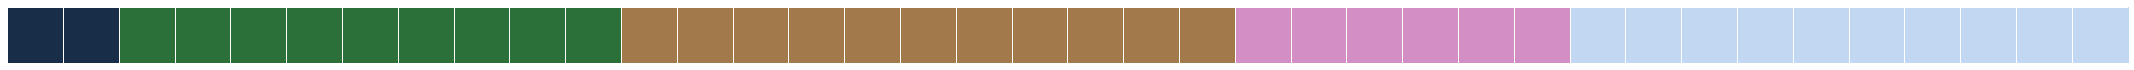

In [86]:
sns.palplot(pal_sub_all)

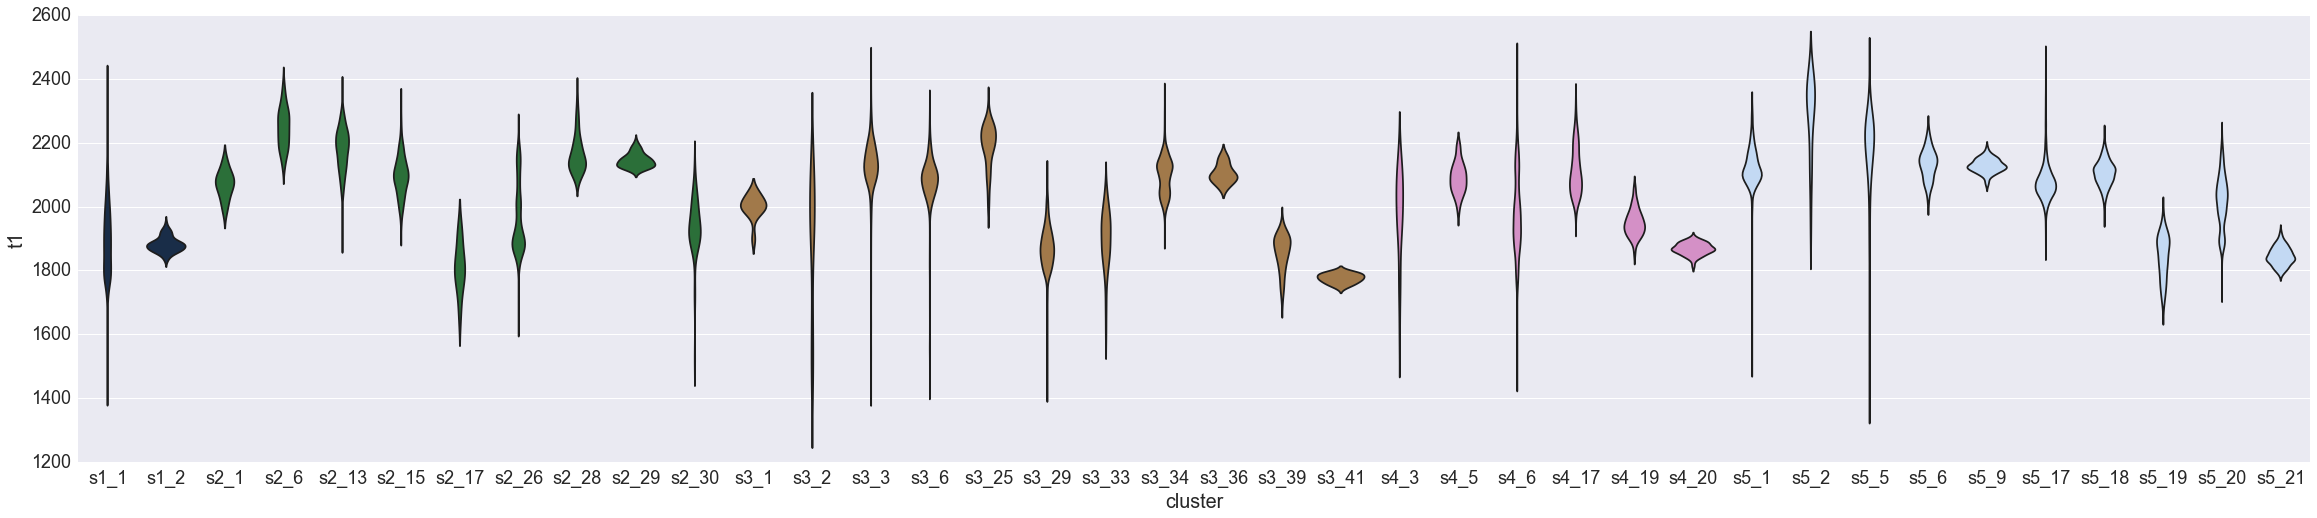

In [89]:
sns.set_context('notebook', font_scale=1.8)
fig = plt.figure(figsize=(40,8))
sns.violinplot(x='cluster', y='t1',data=plot_df, palette=pal_sub, inner=None, saturation=1)
#sns.violinplot(x='cluster', y='t1',data=plot_df, palette=pal_cont[1:], inner='box', saturation=1)
#sns.axlabel('','t1_avg', fontsize=22)
#savefig(fig_file)

In [88]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=clust, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

/usr/lib/python2.7/dist-packages/traits/has_traits.py:1928: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


### sort by means

In [ ]:
means = {}
# The small and mask subclusters have already been removed above
subkeys = Tsubclust.keys()
for sk in range(len(subkeys)):
    means[sk] = np.mean(Tsubclust[sk])
    
sorted_means = sorted(means.items(), key=operator.itemgetter(1))
#sorted_pal = [pal_sub_all[int(sorted_means[p][0][1:])] for p in range(len(sorted_means))] 

sorted_clust = np.zeros_like(clust)
for p in range(len(sorted_means)):
    kp = int(sorted_means[p][0].split('_')[0][1:])
    sp = int(sorted_means[p][0].split('_')[1])
    sorted_clust[np.where(subclust[kp]==sp)]=(p+1)

sorted_plot_list=[]
sorted_cluster_list=[]
for m in range(len(sorted_means)):
    plot_list+=Tsublcust[sorted_means[m][0]]
    cluster_list+=len(Tsubclust[sorted_means[m][0]])*[sorted_means[m][0]]
    
sorted_plot_df=pd.DataFrame(columns=['t1', 'cluster'])
sorted_plot_df['t1']=plot_list
sorted_plot_df['cluster']=cluster_list



pal_cont, pal_cont_255 = make_cont_cmap(len(sorted_means))

In [98]:
sns.set_context('notebook', font_scale=1)
fig = plt.figure(figsize=(40,8))
sns.violinplot(x='cluster', y='t1',data=sorted_plot_df, palette=pal_cont[1:], inner='box', saturation=1)
#sns.axlabel('','t1_avg', fontsize=22)
#savefig(fig_file)

In [109]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=sorted_clust, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_cont_255
mlab.draw()
mlab.show()

'k1_14'